# Dog Breed

## Data exploration

In [1]:
import csv
import matplotlib.pylab as plt
import os
from keras.applications.resnet50 import ResNet50
import numpy as np
import PIL

/Users/BearBurg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
image_label = {}
with open('dataset/labels.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    for row in reader:
        image_name = row[0]
        label = row[1]
        
        if label == 'breed':
            continue
        
        if label not in image_label:
            image_label[label] = set()
            
        image_label[label].add(image_name)


# sorted_dict = sorted(image_label.keys())
# print(sorted_dict)
    

In [ ]:
label_dist = {}
for k,v in image_label.items():
    label_dist[k] = len(v)

sorted_image_label = sorted(label_dist.items()) # sorted by key, return a list of tuples

print(sorted_image_label)

l, c = list(label_dist.keys()), list(label_dist.values())


plt.figure(figsize=(30,70))
plt.barh(l,c)
 
plt.show()


In [2]:
def get_test_label(path):
    labels = []
    for foldername in os.listdir(path):
#         print(foldername)
        if foldername != '.DS_Store':
            names = foldername.split('-')
            l = len(names)
            label = names[1]
            for i in range(2,l):
                label += '-' + names[i]
            labels.append(label)
    return labels

In [ ]:
labels = get_test_label('Images')
labels.sort()
print(labels)

In [10]:
#all/train
def image_size(train_dir):
    width = []
    height = []
    for image_dir in os.listdir(train_dir):
        if image_dir != '.DS_Store':
            image = PIL.Image.open(train_dir + '/' + image_dir)
            width.append(image.size[0])
            height.append(image.size[1])
    return width,height

In [11]:
width,height = image_size('dataset/train')

97
3264


In [39]:
print(len(width))

10222


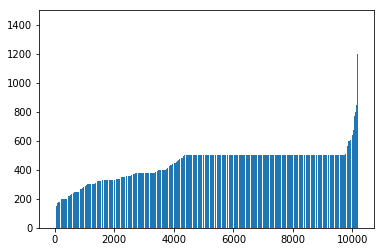

In [23]:
width.sort()
l, c = list(range(len(width))), width
plt.ylim(0,1500)
# plt.figure(figsize=(30,70))
plt.bar(l,c)
plt.show()

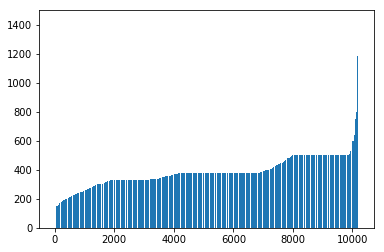

In [25]:
height.sort()
l, c = list(range(len(height))), height
plt.ylim(0,1500)
# plt.figure(figsize=(30,70))
plt.bar(l,c)
plt.show()

In [2]:
from keras.preprocessing import image 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.xception import Xception, preprocess_input
import numpy as np
from glob import glob
from PIL import ImageFile  
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True    
from sklearn.datasets import load_files   
from keras.utils import np_utils
import numpy as np
from glob import glob

In [3]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [105]:
train_files, train_labels = load_dataset('dataset_small/train')
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_files, test_labels = load_dataset('dataset_small/test')
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 1739/1739 [00:08<00:00, 211.34it/s]


In [29]:
xceptionData = np.load('DogXceptionData.npz')
xceptionTrain = xceptionData['train']
# xceptionValid = xceptionData['valid']
xceptionTest = xceptionData['test']

In [44]:
resnet50Data = np.load('DogResnet50Data.npz')
resnet50Train = resnet50Data['train']
resnet50Test = resnet50Data['test']

In [45]:
print(resnet50Train.shape)

(6680, 1, 1, 2048)


In [49]:
resnet50Data_1 = np.load('resnet50data.npz')
resnet50Train_1 = resnet50Data_1['train']
resnet50Test_1 = resnet50Data_1['test']

In [51]:
resnet50Train_1 = np.expand_dims(resnet50Train_1, axis = 1)
resnet50Train_1 = np.expand_dims(resnet50Train_1, axis = 1)


(6680, 1, 1, 2048)


In [54]:
resnet50Test_1 = np.expand_dims(resnet50Test_1, axis = 1)
resnet50Test_1 = np.expand_dims(resnet50Test_1, axis = 1)

In [168]:
def extract_Xception(tensor):
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [194]:
def Xception_transfer_learning(train_Xception,train_targets,length):
    Xception_model = Sequential()
    Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
    Xception_model.add(Dense(512, activation='relu'))
    Xception_model.add(Dropout(0.5))
    Xception_model.add(Dense(length, activation='softmax'))

    Xception_model.summary()
    Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, verbose=0, mode='auto')

    Xception_model.fit(train_Xception, train_targets,epochs=20, batch_size=40, callbacks=[checkpointer, early_stop], verbose=1)
    return Xception_model 

In [60]:
f, labels = load_dataset('dogImages/train')

In [12]:
test_f, test_labels = load_dataset('dogImages/test')

In [200]:
Xception_model = Xception_transfer_learning(xceptionTrain,labels,133)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_23  (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_32 (Dense)             (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6680/6680 [==============================] - 37s 6ms/step - loss: 1.1829 - acc: 0.7018
Epoch 2/20
 120/6680 [..............................] - ETA: 11s - loss: 0.3975 - acc: 0.8583

/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6680/6680 [==============================] - 8s 1ms/step - loss: 0.4594 - acc: 0.8558
Epoch 3/20
6680/6680 [==============================] - 5s 822us/step - loss: 0.3172 - acc: 0.8930
Epoch 4/20
6680/6680 [==============================] - 6s 827us/step - loss: 0.2310 - acc: 0.9223
Epoch 5/20
6680/6680 [==============================] - 5s 810us/step - loss: 0.1802 - acc: 0.9394
Epoch 6/20
6680/6680 [==============================] - 5s 820us/step - loss: 0.1345 - acc: 0.9530
Epoch 7/20
6680/6680 [==============================] - 5s 814us/step - loss: 0.1164 - acc: 0.9632
Epoch 8/20
6680/6680 [==============================] - 6s 844us/step - loss: 0.0908 - acc: 0.9692
Epoch 9/20
6680/6680 [==============================] - 6s 837us/step - loss: 0.0748 - acc: 0.9759
Epoch 10/20
6680/6680 [==============================] - 6s 935us/step - loss: 0.0646 - acc: 0.9790
Epoch 11/20
6680/6680 [==============================] - 6s 972us/step - loss: 0.0678 - acc: 0.9793
Epoch 12/20
6680/6680

In [108]:
def tranfer_learning(trainingData,trainLabels,length):
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=trainingData.shape[1:]))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(length, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
#                                verbose=1, save_best_only=True)

#     early_stop = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, verbose=0, mode='auto')

    model.fit(trainingData, trainLabels, epochs=10, batch_size=20, verbose=1)
    return model

In [70]:
resnet_model = tranfer_learning(resnet50Train,labels,133)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_24  (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6680/6680 [==============================] - 28s 4ms/step - loss: 2.6979 - acc: 0.3719
Epoch 2/20
6680/6680 [==============================] - 10s 2ms/step - loss: 1.1737 - acc: 0.6587
Epoch 3/20
6680/6680 [==============================] - 10s 1ms/step

In [109]:
resnet_model1 = tranfer_learning(resnet50Train_1,labels,133)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_29  (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 133)               133133    
Total params: 2,182,133
Trainable params: 2,182,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6680/6680 [==============================] - 47s 7ms/step - loss: 2.4484 - acc: 0.4328
Epoch 2/10
6680/6680 [==============================] - 14s 2ms/step - loss: 1.0672 - acc: 0.6937
Epoch 3/10
6680/6680 [==============================] - 14s 2ms/step

In [53]:
def calculate_accuracy(model,testData,testLabel,m):
    i = 0
    a = 0
    for test in testData:
        arr = model.predict(np.expand_dims(test,axis = 0))
        idx = np.argsort(-arr[0])[:m]
        if np.argmax(testLabel[i]) in idx:
            a += 1
        i += 1
    return a/len(testLabel)

In [115]:
m = 3
acc = calculate_accuracy(resnet_model,resnet50Test,test_labels,m)
print('top ' + str(m)+ ' accuracy is: ' + str(acc))

top 3 accuracy is: 0.9617224880382775


In [117]:
m = 1
acc = calculate_accuracy(resnet_model1,resnet50Test,test_labels,m)
print('top ' + str(m)+ ' accuracy is: ' + str(acc))

top 1 accuracy is: 0.8026315789473685


In [61]:
m = 3
acc = calculate_accuracy(resnet_model1,resnet50Train_1,labels,m)
print('top ' + str(m)+ ' accuracy is: ' + str(acc))

top 3 accuracy is: 1.0


In [39]:
def make_prediction(labels,model,testData,m):
    labelList = []
    
    for test in testData:
        arr = model.predict(np.expand_dims(test,axis = 0))
        idx = np.argsort(-arr[0])[:m]
        print(idx)
        l = [labels[index] for index in idx]
        labelList.append(l)
        
    return labelList

In [129]:
def extract_Resnet50(tensor):
    return ResNet50(weights='imagenet', include_top=False, pooling="avg").predict(preprocess_input(tensor))

In [118]:
def extract_resnet50_feature(path):
    tensor = paths_to_tensor(path)
    return ResNet50(weights='imagenet', include_top=False, pooling = 'avg').predict(preprocess_input(tensor))

In [81]:
def res50_predictor(labels, model, path, m):
    features = extract_resnet50_feature(path)
#     print([i for i in features])
    features = np.expand_dims(features,axis = 1)
    features = np.expand_dims(features,axis = 1)
    labelList = make_prediction(labels,model,features,m)
    print(labelList)

In [120]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [126]:
m = 3
label_dir = "dogImages/test/*/"
t_files, t_labels = load_dataset('testImage/test')

dog_names = [item[19:-1] for item in sorted(glob(label_dir))]

res50_predictor(dog_names ,resnet_model1,t_files,10)









  0%|          | 0/63 [00:00<?, ?it/s]







  3%|▎         | 2/63 [00:00<00:05, 11.87it/s]







 19%|█▉        | 12/63 [00:00<00:03, 16.12it/s]







 35%|███▍      | 22/63 [00:00<00:01, 21.47it/s]







 51%|█████     | 32/63 [00:00<00:01, 28.00it/s]







 71%|███████▏  | 45/63 [00:00<00:00, 36.54it/s]







 87%|████████▋ | 55/63 [00:00<00:00, 44.71it/s]







100%|██████████| 63/63 [00:00<00:00, 80.19it/s]

[ 23  47   5   7  48  89 100  15 122 107]
[ 23  47   7  48   5  15 100  89  80  42]
[ 23  47 100   7  48   5  81  45  90  89]
[ 23  47   5   7  48 100  89  15  90 122]
[ 23  47   5   7  48 122 100  89 107 123]
[ 23  48   5  47 100   7  89 122  81  90]
[ 23   7  47   5  48 100  15  89  90  81]
[ 23   7  47   5  15  48 100  89  80 107]
[ 23   5  47  48 100 122   7  89  81  90]
[ 23  47   7   5  48 100  15  89 123 107]
[ 23   7  47  48 100   5  15  89  80  81]
[ 48 100  23   5  47  81  89 122   7  90]
[ 23  48 100  47   7   5  89  81  38  80]
[ 23  47   5  48 100   7 122  90  89  81]
[ 23   7  47 100  48   5  89  81  80  38]
[ 23  47   7   5  48 100  15  89  80 107]
[ 23  47   7   5  48 100  89  15  80 107]
[ 23  47   7   5  15  48 100  80  89 107]
[ 23   5  47   7  48  15 107 100 123  89]
[100  23  48  81  47   5   7  99  90  89]
[ 23  47   5   7  48 100  89  15 122  90]
[ 23  47 100  48   7   5  81  90  15  89]
[ 23  48   5  47   7 100 122  89  83  90]
[ 23   7  47   5  48  15 100  89  

In [130]:
tt_files_name = "testImage/test"
tt_files, tt_targets = load_dataset(tt_files_name)
tt_tensors = paths_to_tensor(tt_files)
tt_features_resnet50 = extract_Resnet50(tt_tensors)
tt_features_resnet50 = np.expand_dims(tt_features_resnet50, axis=1)
tt_features_resnet50 = np.expand_dims(tt_features_resnet50, axis=1)

make_prediction(dog_names,resnet_model1,tt_features_resnet50,3)









  0%|          | 0/63 [00:00<?, ?it/s]







  5%|▍         | 3/63 [00:00<00:02, 29.36it/s]







 22%|██▏       | 14/63 [00:00<00:01, 37.07it/s]







 37%|███▋      | 23/63 [00:00<00:00, 43.46it/s]







 56%|█████▌    | 35/63 [00:00<00:00, 53.50it/s]







 76%|███████▌  | 48/63 [00:00<00:00, 64.77it/s]







 92%|█████████▏| 58/63 [00:00<00:00, 70.96it/s]







100%|██████████| 63/63 [00:00<00:00, 88.79it/s]

[23 47  5]
[23 47  7]
[ 23  47 100]
[23 47  5]
[23 47  5]
[23 48  5]
[23  7 47]
[23  7 47]
[23  5 47]
[23 47  7]
[23  7 47]
[ 48 100  23]
[ 23  48 100]
[23 47  5]
[23  7 47]
[23 47  7]
[23 47  7]
[23 47  7]
[23  5 47]
[100  23  48]
[23 47  5]
[ 23  47 100]
[23 48  5]
[23  7 47]
[23 47  7]
[23  7 47]
[23  5 48]
[23 47  5]
[23  5 47]
[23 47  7]
[23 47  7]
[23 47  7]
[ 23 100   5]
[23 48 47]
[23 47  5]
[23 47  7]
[23 47  5]
[23 47  7]
[23 47  5]
[23 47  7]
[ 23 100  48]
[23  5 47]
[23 47  7]
[ 23   7 100]
[23 47  7]
[23  5 47]
[23 47  7]
[23  7  5]
[23 47  7]
[23 47  7]
[23  5 47]
[ 5 48 23]
[23  5 47]
[23 47  7]
[23 47  5]
[23 47  7]
[ 23 100  47]
[ 23 100  48]
[ 23  47 100]
[23 47  7]
[23 47  7]
[23 47  5]
[23 47  7]


[['Bichon_frise', 'Chihuahua', 'American_eskimo_dog'],
 ['Bichon_frise', 'Chihuahua', 'American_staffordshire_terrier'],
 ['Bichon_frise', 'Chihuahua', 'Maltese'],
 ['Bichon_frise', 'Chihuahua', 'American_eskimo_dog'],
 ['Bichon_frise', 'Chihuahua', 'American_eskimo_dog'],
 ['Bichon_frise', 'Chinese_crested', 'American_eskimo_dog'],
 ['Bichon_frise', 'American_staffordshire_terrier', 'Chihuahua'],
 ['Bichon_frise', 'American_staffordshire_terrier', 'Chihuahua'],
 ['Bichon_frise', 'American_eskimo_dog', 'Chihuahua'],
 ['Bichon_frise', 'Chihuahua', 'American_staffordshire_terrier'],
 ['Bichon_frise', 'American_staffordshire_terrier', 'Chihuahua'],
 ['Chinese_crested', 'Maltese', 'Bichon_frise'],
 ['Bichon_frise', 'Chinese_crested', 'Maltese'],
 ['Bichon_frise', 'Chihuahua', 'American_eskimo_dog'],
 ['Bichon_frise', 'American_staffordshire_terrier', 'Chihuahua'],
 ['Bichon_frise', 'Chihuahua', 'American_staffordshire_terrier'],
 ['Bichon_frise', 'Chihuahua', 'American_staffordshire_terrie

In [131]:
tt = np.load('tt50data.npz')['test']
make_prediction(dog_names,resnet_model1,tt,3)

[ 3  5 42]
[ 3 50 66]
[ 3  9 42]
[ 3 83 66]
[ 3 42 83]
[  3 107  50]
[  3 107  66]
[ 3 42  5]
[  3   9 108]
[  3  42 107]
[ 3 50 66]
[ 3 83  4]
[ 3 83 78]
[ 3 78  5]
[  3 108   4]
[  3 107  42]
[  3 107  42]
[  3 107  50]
[ 3 83  4]
[ 3 66 50]
[ 3 83 66]
[ 3 50 66]
[  3 108   4]
[ 3 42  9]
[ 3 42  5]
[  3  83 107]
[19 70  3]
[108   3  50]
[ 3 42 83]
[  3 107  42]
[  3 107  42]
[  3   9 107]
[ 3 19  9]
[  3  83 107]
[ 3 83 44]
[ 3 42 38]
[  3 107  66]
[ 3 83 66]
[  3 108   9]
[ 3 83 42]
[ 3 42 38]
[  3  83 107]
[  3   9 108]
[ 3  4 83]
[50  3 83]
[  3 107  66]
[  3   9 108]
[108   3   9]
[ 3 42  9]
[ 3 66 50]
[ 3 66 83]
[ 3  9 42]
[  3   5 107]
[ 3 70 21]
[ 3 83  4]
[ 3 42  9]
[ 3 42  9]
[ 3 83 91]
[108   3  19]
[ 3 66 83]
[  3 127  42]
[  3 108   9]
[ 3 66 50]


[['Akita', 'American_eskimo_dog', 'Canaan_dog'],
 ['Akita', 'Chow_chow', 'Finnish_spitz'],
 ['Akita', 'Anatolian_shepherd_dog', 'Canaan_dog'],
 ['Akita', 'Icelandic_sheepdog', 'Finnish_spitz'],
 ['Akita', 'Canaan_dog', 'Icelandic_sheepdog'],
 ['Akita', 'Norwegian_buhund', 'Chow_chow'],
 ['Akita', 'Norwegian_buhund', 'Finnish_spitz'],
 ['Akita', 'Canaan_dog', 'American_eskimo_dog'],
 ['Akita', 'Anatolian_shepherd_dog', 'Norwegian_elkhound'],
 ['Akita', 'Canaan_dog', 'Norwegian_buhund'],
 ['Akita', 'Chow_chow', 'Finnish_spitz'],
 ['Akita', 'Icelandic_sheepdog', 'Alaskan_malamute'],
 ['Akita', 'Icelandic_sheepdog', 'Great_pyrenees'],
 ['Akita', 'Great_pyrenees', 'American_eskimo_dog'],
 ['Akita', 'Norwegian_elkhound', 'Alaskan_malamute'],
 ['Akita', 'Norwegian_buhund', 'Canaan_dog'],
 ['Akita', 'Norwegian_buhund', 'Canaan_dog'],
 ['Akita', 'Norwegian_buhund', 'Chow_chow'],
 ['Akita', 'Icelandic_sheepdog', 'Alaskan_malamute'],
 ['Akita', 'Finnish_spitz', 'Chow_chow'],
 ['Akita', 'Icelandic

In [103]:
def transfer_learning_Xception(train_dir, batch_size,class_num,epoch = 10, samples_per_epoch = 100, transformation_ratio = .05):
    xception_width = 299
    xception_height = 299
#     class_num = 10
    base_model = Xception(input_shape=(xception_width, xception_height, 3), weights='imagenet', include_top=False)

    # Top Model Block
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(class_num, activation='softmax')(x)

    # add your top layer block to base model
    model = Model(base_model.input, predictions)
#     print(model.summary())
    for layer in base_model.layers:
        layer.trainable = False 
#     train_datagen = ImageDataGenerator(rescale=1. / 255,
#                                        rotation_range=transformation_ratio,
#                                        shear_range=transformation_ratio,
#                                        zoom_range=transformation_ratio,
#                                        cval=transformation_ratio,
#                                        horizontal_flip=True,
#                                        vertical_flip=True)
    train_datagen = ImageDataGenerator(rescale=1. / 255)

#     validation_datagen = ImageDataGenerator(rescale=1. / 255)
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(xception_width, xception_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
    filenames = train_generator.filenames
    nb_sample = len(filenames)
    print(nb_sample)
    model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, verbose=0, mode='auto')
    model.fit_generator(train_generator,
                        samples_per_epoch=100,
                        nb_epoch = epoch,callbacks=[checkpointer, early_stop])
    print('done training')
    return model

In [104]:
model = transfer_learning_Xception('dataset_small/train',20,10,epoch = 5)

Found 870 images belonging to 10 classes.
870


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=5, epochs=5)`


Epoch 1/5
5/5 [==============================] - 65s 13s/step - loss: 2.0961 - acc: 0.3000
Epoch 2/5


/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


5/5 [==============================] - 47s 9s/step - loss: 1.3748 - acc: 0.8100
Epoch 3/5
5/5 [==============================] - 40s 8s/step - loss: 0.9841 - acc: 0.8900
Epoch 4/5
5/5 [==============================] - 39s 8s/step - loss: 0.5879 - acc: 0.9400
Epoch 5/5
5/5 [==============================] - 45s 9s/step - loss: 0.3475 - acc: 0.9900
done training


In [133]:
def test_xception(test_dir):
    xception_width = 299
    xception_height = 299
    batch_size = 20
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    print(test_datagen)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(xception_width, xception_height),
                                                        batch_size=1739,
                                                        class_mode='categorical')
    X,y =  test_generator.next()
    return X,y

In [134]:
test_data,test_label = test_xception('dataset_small/test')

Found 1739 images belonging to 10 classes.


In [123]:
print(test_label)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [135]:
res = [np.argmax(model.predict(np.expand_dims(test,axis = 0))) for test in test_data]
a = 100* np.sum(res == np.argmax(test_label, axis = 1))/len(test_label)
print(a)

0.3450258769407706


In [266]:
arr = [1,2,3,4,5,6]
arr = np.array(arr)

In [275]:
idx = (-arr).argsort()[:1]
print(idx)

[5]
